Saving GSE66939_leo1_H3K9me2_res25.wig.gz to GSE66939_leo1_H3K9me2_res25.wig (6).gz
Saving GSE66939_wt_H3K9me2_res25.wig.gz to GSE66939_wt_H3K9me2_res25.wig (6).gz
Available chromosomes: ['II', 'AB325691', 'MTR', 'III', 'I', 'MT']
Enter chromosome (e.g., I, II, III): II
WT range: 163 - 4539738
leo1Δ range: 113 - 4539763
Enter starting basepair: 1150000
Enter ending basepair: 1200000

🟠 leo1Δ peak regions (baseline + tol=1e-10):
  Peak 1: 1,161,492–1,162,686, peak at 1,161,731, height=9.60e-04
  Peak 2: 1,167,983–1,168,365, peak at 1,168,055, height=9.45e-04
  Peak 3: 1,169,152–1,170,560, peak at 1,169,749, height=9.62e-04
dx=23.9, suggested dt<2.8e+00

--- Optimized Parameters ---
D=100.00, beta=1.00e-05, n=2.00, gamma=1.00


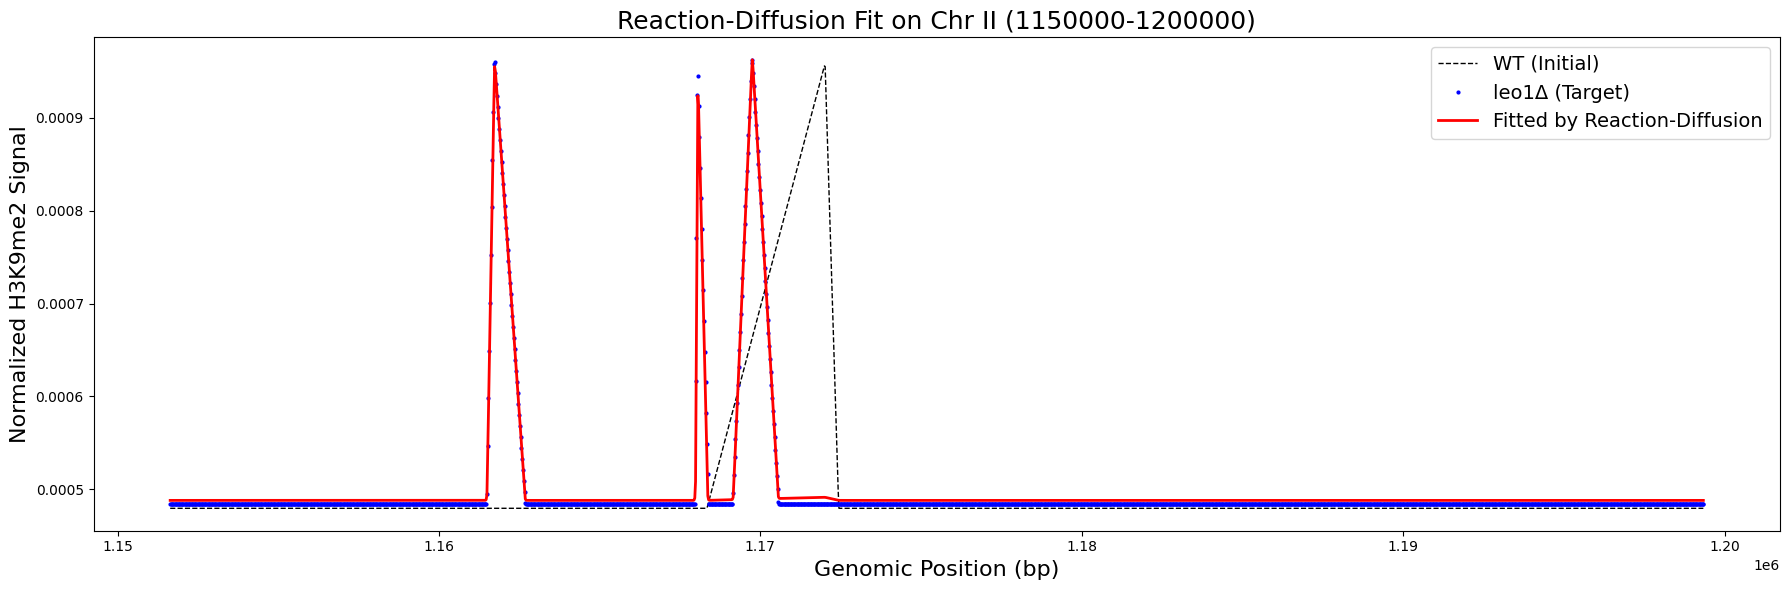


--- Goodness of Fit ---
MSE        = 4.14e-11
R²         = 0.9913
Pearson r  = 0.9969
Residual mean: -2.92e-06, std: 5.74e-06


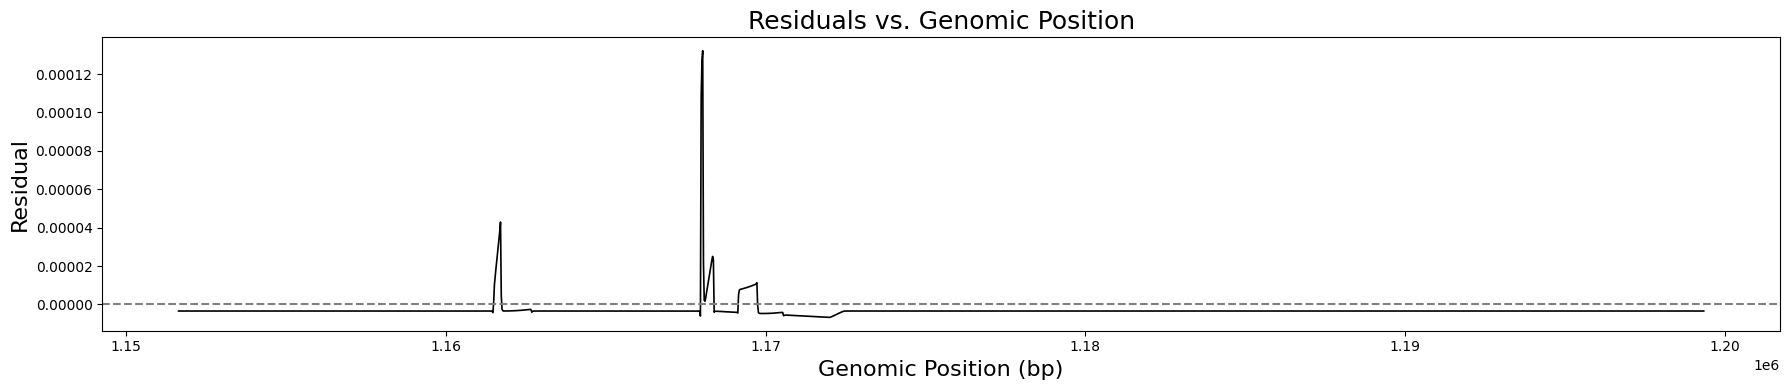

In [7]:
# ============================================
# 📦 Imports and Setup
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize
import gzip, re
from collections import defaultdict
from google.colab import files

# ============================================
# 📁 Upload and Parse WIG Files
# ============================================
uploaded = files.upload()
wt_file = [f for f in uploaded if "wt" in f.lower()][0]
leo1_file = [f for f in uploaded if "leo1" in f.lower()][0]

def parse_wig_by_chrom(filename):
    chrom_data = defaultdict(list)
    with gzip.open(filename, 'rt') as f:
        current_chrom = None
        for line in f:
            line = line.strip()
            if line.startswith("variableStep"):
                m = re.search(r'chrom=([^\s]+)', line)
                if m: current_chrom = m.group(1)
            elif line and not line.startswith("track") and current_chrom:
                parts = line.split()
                if len(parts) == 2:
                    try:
                        chrom_data[current_chrom].append((int(parts[0]), float(parts[1])))
                    except: continue
    return {chrom: pd.DataFrame(data, columns=['pos','signal']).sort_values('pos')
            for chrom, data in chrom_data.items()}

wt_chroms = parse_wig_by_chrom(wt_file)
leo1_chroms = parse_wig_by_chrom(leo1_file)

# ============================================
# 📌 User Inputs
# ============================================
print("Available chromosomes:", list(wt_chroms.keys()))
chrom = input("Enter chromosome (e.g., I, II, III): ").strip()

if chrom in wt_chroms and chrom in leo1_chroms:
    wt_df = wt_chroms[chrom]
    leo1_df = leo1_chroms[chrom]

    print(f"WT range: {wt_df['pos'].min()} - {wt_df['pos'].max()}")
    print(f"leo1Δ range: {leo1_df['pos'].min()} - {leo1_df['pos'].max()}")

    start_bp = int(input("Enter starting basepair: "))
    end_bp   = int(input("Enter ending basepair: "))

    # ============================================
    # 🔄 Subset, interpolate and normalize
    # ============================================
    wt_sub = wt_df[(wt_df['pos'] >= start_bp) & (wt_df['pos'] <= end_bp)]
    leo1_sub = leo1_df[(leo1_df['pos'] >= start_bp) & (leo1_df['pos'] <= end_bp)]

    x_min = max(wt_sub['pos'].min(), leo1_sub['pos'].min())
    x_max = min(wt_sub['pos'].max(), leo1_sub['pos'].max())
    x_uniform = np.linspace(x_min, x_max, 2000)

    wt_interp = interp1d(wt_sub['pos'], wt_sub['signal'], bounds_error=False, fill_value=0)
    leo1_interp = interp1d(leo1_sub['pos'], leo1_sub['signal'], bounds_error=False, fill_value=0)

    wt_signal = wt_interp(x_uniform)
    leo1_signal = leo1_interp(x_uniform)

    wt_norm = wt_signal / np.sum(wt_signal) if np.sum(wt_signal)!=0 else wt_signal
    leo1_norm = leo1_signal / np.sum(leo1_signal) if np.sum(leo1_signal)!=0 else leo1_signal

    # ============================================
    # 🛠 Detect leo1Δ peak regions above baseline
    # ============================================
    slope = np.gradient(leo1_norm)
    flat_idx = np.where(np.abs(slope) < 1e-9)[0]
    leo_baseline = np.mean(leo1_norm[flat_idx]) if len(flat_idx)>0 else np.median(leo1_norm)

    tolerance = 1e-10
    mask = leo1_norm > leo_baseline + tolerance

    regions = []
    in_region = False
    for i, val in enumerate(mask):
        if val and not in_region:
            start_idx = i
            in_region = True
        elif not val and in_region:
            regions.append((start_idx, i - 1))
            in_region = False
    if in_region:
        regions.append((start_idx, len(mask) - 1))

    print(f"\n🟠 leo1Δ peak regions (baseline + tol={tolerance}):")
    alpha_target = np.full_like(x_uniform, leo_baseline)
    for i, (s, e) in enumerate(regions, 1):
        peak_idx = s + np.argmax(leo1_norm[s:e+1])
        peak_height = leo1_norm[peak_idx]
        center = x_uniform[peak_idx]
        region_start = x_uniform[s]
        region_end = x_uniform[e]
        print(f"  Peak {i}: {int(region_start):,}–{int(region_end):,}, peak at {int(center):,}, height={peak_height:.2e}")

        # Make narrow triangle at detected peak:
        left = (x_uniform >= region_start) & (x_uniform <= center)
        right = (x_uniform > center) & (x_uniform <= region_end)
        alpha_target[left] += (peak_height - leo_baseline)*(x_uniform[left]-region_start)/(center - region_start)
        alpha_target[right] += (peak_height - leo_baseline)*(region_end - x_uniform[right])/(region_end - center)

    # ============================================
    # ⚙️ Discretization
    # ============================================
    dx = x_uniform[1]-x_uniform[0]
    dt = 1e-3
    print(f"dx={dx:.1f}, suggested dt<{0.5*dx**2/100:.1e}")

    # ============================================
    # 🧪 Reaction-Diffusion simulation
    # ============================================
    def simulate(params, n_steps=5000, dt=dt):
        D, beta, n, gamma = params
        K = 6.7e-04
        m = wt_norm.copy()
        for _ in range(n_steps):
            d2m_dx2 = np.zeros_like(m)
            d2m_dx2[1:-1] = (m[:-2] - 2*m[1:-1] + m[2:]) / dx**2
            d2m_dx2[0] = d2m_dx2[1]
            d2m_dx2[-1] = d2m_dx2[-2]
            hill = beta * (m**n) / (K**n + m**n + 1e-12)
            dm_dt = D*d2m_dx2 + alpha_target - gamma*m + hill
            m += dt*dm_dt
            m = np.clip(m, 0, None)
        return m

    # ============================================
    # 📉 Loss function
    # ============================================
    def loss(params):
        pred = simulate(params)
        return np.mean((pred - leo1_norm)**2)

    # ============================================
    # 🔧 Optimize parameters
    # ============================================
    p0 = [100, 1e-3, 2.0, 1.0]
    bounds = [(10,500), (1e-5,1e-2), (1.0,4.0), (0.5,2.0)]
    result = minimize(loss, p0, bounds=bounds, method='L-BFGS-B')
    print("\n--- Optimized Parameters ---")
    print(f"D={result.x[0]:.2f}, beta={result.x[1]:.2e}, n={result.x[2]:.2f}, gamma={result.x[3]:.2f}")

    # ============================================
    # 📊 Plot fit
    # ============================================
    m_fit = simulate(result.x)

    plt.figure(figsize=(18, 6))
    plt.plot(x_uniform, wt_norm, '--', color='k', label='WT (Initial)', lw=1)
    plt.plot(x_uniform, leo1_norm, 'o', color='blue', markersize=2, label='leo1Δ (Target)')
    plt.plot(x_uniform, m_fit, '-', color='red', label='Fitted by Reaction-Diffusion', lw=2)
    plt.xlabel("Genomic Position (bp)", fontsize=16)
    plt.ylabel("Normalized H3K9me2 Signal", fontsize=16)
    plt.title(f"Reaction-Diffusion Fit on Chr {chrom} ({start_bp}-{end_bp})", fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()

    # ============================================
    # 📉 Residuals & stats
    # ============================================
    final_residuals = leo1_norm - m_fit
    mse = mean_squared_error(leo1_norm, m_fit)
    r2 = r2_score(leo1_norm, m_fit)
    pearson_r, _ = pearsonr(leo1_norm, m_fit)

    print("\n--- Goodness of Fit ---")
    print(f"MSE        = {mse:.2e}")
    print(f"R²         = {r2:.4f}")
    print(f"Pearson r  = {pearson_r:.4f}")
    print(f"Residual mean: {np.mean(final_residuals):.2e}, std: {np.std(final_residuals):.2e}")

    # ============================================
    # 📊 Residual plot
    # ============================================
    plt.figure(figsize=(18, 4))
    plt.plot(x_uniform, final_residuals, color='black', lw=1.2, label='Residuals')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("Residuals vs. Genomic Position", fontsize=18)
    plt.xlabel("Genomic Position (bp)", fontsize=16)
    plt.ylabel("Residual", fontsize=16)
    plt.tight_layout()
    plt.show()